# 0.0 Import

In [33]:
import pickle
import numpy        as np
import pandas       as pd
import scikitplot   as skplt
import xgboost      as xgb

from matplotlib import pyplot as plt

from IPython.display import HTML

from sklearn import neighbors       as nh
from sklearn import linear_model    as lm

from sklearn.ensemble           import ExtraTreesClassifier
from sklearn.ensemble           import RandomForestClassifier
from sklearn.naive_bayes        import GaussianNB
from sklearn.model_selection    import cross_validate, cross_val_score
from sklearn.metrics            import make_scorer

## 0.1 Help Functions

In [34]:
# Supressão de Notação Científica
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.6f}'.format)

In [35]:
def precision_at_k (data, k=2000):

    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [36]:
def recall_at_k (data, k=2000 ):

    data['ranking'] = data.index +1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [37]:
def precision_at_k_meu (y_true, y_score, k=10):
    
    df = pd.DataFrame({'response': y_true, 'score': y_score})
    df = df.sort_values(by='score', ascending=False)
    df = df[['response', 'score']].reset_index()
    df = df.rename(columns={'index':'id'})
    
    df['ranking'] = df.index + 1
    df['precision_at_k'] = df['response'].cumsum() / df['ranking']
    
    return df.loc[k, 'precision_at_k']

In [38]:
def recall_at_k_meu (y_true, y_score, k=10):
    
    df = pd.DataFrame({'response': y_true, 'score': y_score})
    df = df.sort_values(by='score', ascending=False)
    df = df[['response', 'score']].reset_index()
    df = df.rename(columns={'index':'id'})
    
    df['ranking'] = df.index +1
    df['recall_at_k'] = df['response'].cumsum() / df['response'].sum()
    
    return df.loc[k, 'recall_at_k']

In [39]:
def modelo(yhat_modelo, y_validacao, x_validacao):
    df = x_validacao.copy()
    df['response'] = y_validacao.copy()
    df['score'] = yhat_modelo[:,1].tolist()
    df = df.sort_values(by='score', ascending=False)
    df = df[['response', 'score']].reset_index()
    df = df.rename(columns={'index':'id'})
    
    return df

## 0.2 Load processed data

In [40]:
x_treino = pickle.load( open( '../data/processed/x_treino.pkl', 'rb' ) )
y_treino = pickle.load( open( '../data/processed/y_treino.pkl', 'rb' ) )

x_validacao = pickle.load( open( '../data/processed/x_validacao.pkl', 'rb' ) )
y_validacao = pickle.load( open( '../data/processed/y_validacao.pkl', 'rb') )

In [41]:
x_full = pd.concat([x_treino, x_validacao])
y_full = pd.concat([y_treino, y_validacao])

# 1.0 Modelos de Machine Learning

## 1.1 KNN

In [42]:
knn_model = nh.KNeighborsClassifier( n_neighbors=5 )

knn_model.fit(x_treino, y_treino)

yhat_knn_proba = knn_model.predict_proba(x_validacao)

yhat_knn_predict = knn_model.predict(x_validacao)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

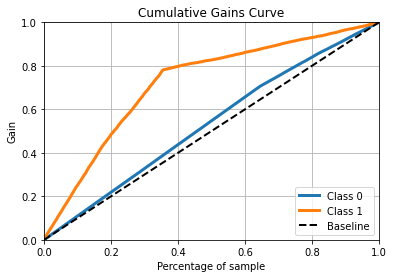

In [43]:
skplt.metrics.plot_cumulative_gain(y_validacao, yhat_knn_proba)

In [44]:
knn_cross_precision = cross_val_score(knn_model, x_full, y_full, cv=5, 
                                        scoring=make_scorer(precision_at_k_meu, k=20000, greater_is_better=True))

knn_cross_recall = cross_val_score(knn_model, x_full, y_full, cv=5,
                                   scoring=make_scorer(recall_at_k_meu, k=20000, greater_is_better=True))

In [45]:
print(knn_cross_precision)
print(knn_cross_recall)

[0.15704215 0.16134193 0.1619919  0.16674166 0.15924204]
[0.33622351 0.34542924 0.34682081 0.35698994 0.34093342]


In [46]:
print(knn_cross_precision.mean())
print(knn_cross_recall.mean())

0.16127193640317986
0.34527938342967246


## 1.2 Logistic Regression

In [47]:
lr_model = lm.LogisticRegression(random_state=42)

lr_model.fit(x_treino, y_treino)

yhat_lr_proba = lr_model.predict_proba(x_validacao)

yhat_lr_predict = lr_model.predict(x_validacao)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

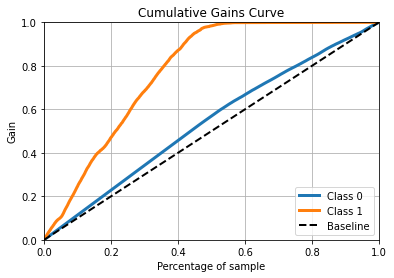

In [48]:
skplt.metrics.plot_cumulative_gain(y_validacao, yhat_lr_proba)

In [49]:
lr_cross_precision = cross_val_score(lr_model, x_full, y_full, cv=5, 
                                        scoring=make_scorer(precision_at_k_meu, k=20000, greater_is_better=True))

lr_cross_recall = cross_val_score(lr_model, x_full, y_full, cv=5,
                                   scoring=make_scorer(recall_at_k_meu, k=20000, greater_is_better=True))

In [50]:
print(lr_cross_precision)
print(lr_cross_recall)

[0.12169392 0.12149393 0.12174391 0.12289386 0.12469377]
[0.26054378 0.26011561 0.26065082 0.26311282 0.26696639]


In [51]:
print(lr_cross_precision.mean())
print(lr_cross_recall.mean())

0.12250387480625968
0.26227788482123743


## 1.3 Random Forest

In [52]:
rf_model = RandomForestClassifier(n_estimators = 15, random_state = 42)

rf_model.fit(x_treino, y_treino)

yhat_rf_proba = rf_model.predict_proba(x_validacao)

yhat_rf_predict = rf_model.predict(x_validacao)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

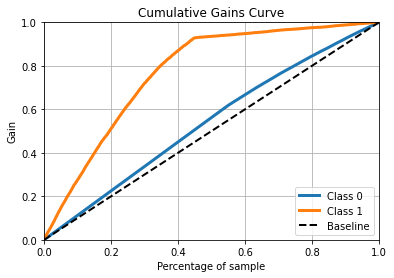

In [53]:
skplt.metrics.plot_cumulative_gain(y_validacao, yhat_rf_proba)

In [54]:
rf_cross_precision = cross_val_score(rf_model, x_full, y_full, cv=5, 
                                        scoring=make_scorer(precision_at_k_meu, k=20000, greater_is_better=True))

rf_cross_recall = cross_val_score(rf_model, x_full, y_full, cv=5,
                                   scoring=make_scorer(recall_at_k_meu, k=20000, greater_is_better=True))

In [55]:
print(rf_cross_precision)
print(rf_cross_recall)

[0.16149193 0.15844208 0.15779211 0.15864207 0.16244188]
[0.34575037 0.33922072 0.33782916 0.3396489  0.3477842 ]


In [56]:
print(rf_cross_precision.mean())
print(rf_cross_recall.mean())

0.15976201189940503
0.342046670948405


## 1.4 Extra Trees Classifier

In [57]:
et_model = ExtraTreesClassifier( n_estimators = 10, n_jobs=-1, random_state = 42)

et_model.fit(x_treino, y_treino)

yhat_et = et_model.predict_proba(x_validacao)

yhat_et_proba = et_model.predict_proba(x_validacao)

yhat_et_predict = et_model.predict(x_validacao)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

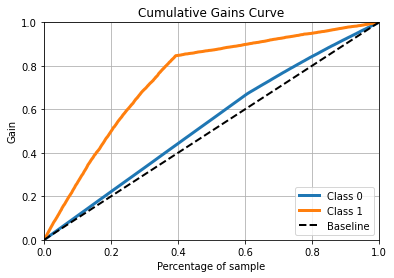

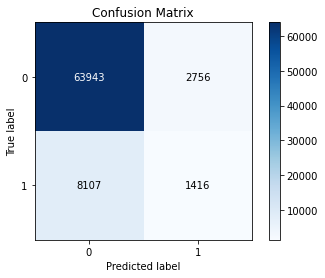

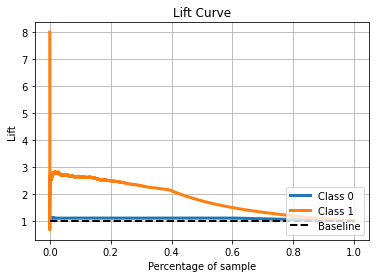

In [58]:
skplt.metrics.plot_cumulative_gain(y_validacao, yhat_et_proba)

skplt.metrics.plot_confusion_matrix(y_validacao, yhat_et_predict)

skplt.metrics.plot_lift_curve(y_validacao, yhat_et_proba)

In [59]:
et_cross_precision = cross_val_score(et_model, x_full, y_full, cv=5, 
                                        scoring=make_scorer(precision_at_k_meu, k=20000, greater_is_better=True))

et_cross_recall = cross_val_score(et_model, x_full, y_full, cv=5,
                                   scoring=make_scorer(recall_at_k_meu, k=20000, greater_is_better=True))

In [60]:
print(et_cross_precision)
print(et_cross_recall)

[0.15614219 0.15439228 0.15654217 0.15619219 0.16029199]
[0.33429672 0.3305502  0.33515307 0.33440377 0.34318133]


In [61]:
print(et_cross_precision.mean())
print(et_cross_recall.mean())

0.15671216439178043
0.33551701991008354


## 1.5 XGBoost

In [62]:
xgb_model = xgb.XGBClassifier()

xgb_model.fit(x_treino, y_treino)

yhat_xgb_proba = xgb_model.predict_proba(x_validacao)

yhat_xgb_predict = xgb_model.predict(x_validacao)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

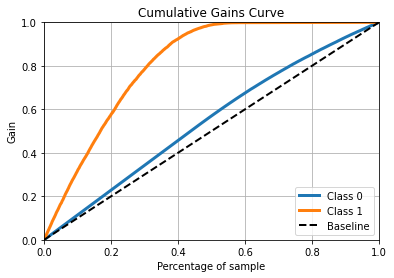

In [63]:
skplt.metrics.plot_cumulative_gain(y_validacao, yhat_xgb_proba)

In [64]:
xgb_cross_precision = cross_val_score(xgb_model, x_full, y_full, cv=5, 
                                        scoring=make_scorer(precision_at_k_meu, k=20000, greater_is_better=True))

xgb_cross_recall = cross_val_score(xgb_model, x_full, y_full, cv=5,
                                   scoring=make_scorer(recall_at_k_meu, k=20000, greater_is_better=True))

In [65]:
print(xgb_cross_precision)
print(xgb_cross_recall)

[0.12614369 0.12564372 0.12449378 0.12559372 0.12769362]
[0.27007065 0.26900021 0.26653821 0.26889317 0.273389  ]


In [66]:
print(xgb_cross_precision.mean())
print(xgb_cross_recall.mean())

0.12591370431478427
0.2695782487690002


## 1.6 Naive Bayes

In [67]:
gnv_model = GaussianNB()

gnv_model.fit(x_treino, y_treino)

yhat_gnv_proba = gnv_model.predict_proba(x_validacao)

yhat_gnv_predict = gnv_model.predict(x_validacao)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

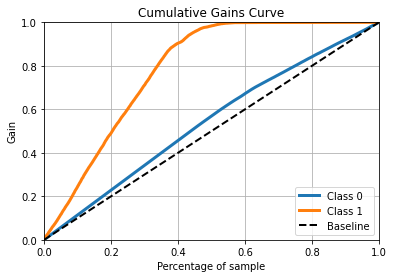

In [68]:
skplt.metrics.plot_cumulative_gain(y_validacao, yhat_gnv_proba)

In [69]:
gnv_cross_precision = cross_val_score(gnv_model, x_full, y_full, cv=5, 
                                        scoring=make_scorer(precision_at_k_meu, k=20000, greater_is_better=True))

gnv_cross_recall = cross_val_score(gnv_model, x_full, y_full, cv=5,
                                   scoring=make_scorer(recall_at_k_meu, k=20000, greater_is_better=True))

In [70]:
print(gnv_cross_precision)
print(gnv_cross_recall)

[0.25033748 0.24768762 0.24673766 0.25328734 0.25413729]
[0.5359666  0.5302933  0.52825947 0.54228217 0.54410191]


In [71]:
print(gnv_cross_precision.mean())
print(gnv_cross_recall.mean())

0.2504374781260937
0.5361806893598802


## 2.0 Performance dos Modelos

## 3.0 Exportando os Modelos

In [72]:
pickle.dump(gnv_model, open('../src/models/gnv_model.pkl', 'wb'))